# <span id="toc">  Esercizio 12 - Riconoscimento di immagini tramite Deep & Convolutional NN </span>

- [Esercizio 12.1](#ex012_1)

- [Esercizio 12.2](#ex012_2)

- [Esercizio 12.3](#ex012_3)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam

In questo esercizio utilizzerò il dataset **MNIST**, che contiene $70.000$ immagini in scala di grigi di cifre scritte a mano (da $0$ a $9$), in forma di matrice 28x28. 

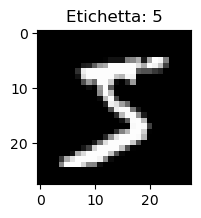

In [2]:
(X,Y), (_,_) = mnist.load_data()
plt.figure(figsize=(2,2)), plt.imshow(X[0], cmap='gray'), plt.title(f'Etichetta: {Y[0]}')
plt.show()

L’obiettivo è costruire e addestrare una rete neurale in grado di classificare correttamente le cifre. 
Si tratta quindi di un tipico problema di classificazione multiclasse, con 10 possibili classi di output, una per ogni cifra.

- **Deep Neural Network (DNN)**: composta da layer densi, riceve come input il vettore dei pixel di ogni immagine e impara a distinguere le diverse cifre.  
- **Convolutional Neural Network (CNN)**: sfrutta la struttura spaziale delle immagini tramite operazioni di convoluzione, riuscendo a riconoscere bordi e forme con maggiore precisione, quindi è più efficace per i problemi di riconoscimento di immagini.

Lo scopo finale è quello di capire come cambia la performance dei modelli passando da un’architettura densa a una convoluzionale, e osservare come la rete neurale riesce ad imparare le caratteristiche delle cifre scritte a mano.  

## <span id="ex012_1">  Esercizio 12.1 </span>[^](#toc)

Il lavoro si articola nei seguenti passaggi principali:
1. **Caricamento e preprocessing dei dati**: preparare le immagini e le etichette in un formato adatto all’addestramento della NN.  
2. **Definizione dell’architettura**: costruire il modello scegliendo i layer e le funzioni di attivazione.
3. **Compilazione del modello**: selezionare l’ottimizzatore, la funzione di loss e le metriche da monitorare.
4. **Addestramento**: eseguire il training del modello sui dati di training, validandolo con un set di test. 
5. **Valutazione delle prestazioni**: misurare l’accuratezza e la capacità di generalizzazione del modello su nuovi dati.

In questa prima parte userò una rete neurale profonda per affrontare il problema della classificazione delle cifre.
L’idea è quella di costruire una rete simile a quella già usata nell'Esercizio 11, composta da più layer densi, in cui ogni neurone è connesso a tutti quelli del layer precedente.  

Per poter essere utilizzate in questo tipo di architettura, le immagini 28x28 del dataset MNIST vengono convertite in un vettore di $784$ valori.  



In [3]:
# Input image dimensions
img_rows, img_cols = 28, 28 # Number of pixels 
# Output
num_classes = 10            # 10 digits

In [4]:
# 1. Load and process data
# Train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Reshape data
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# Cast to floats and rescale data in interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [5]:
# 2. Define DNN architecture
def create_DNN():
    # Instantiate model
    model = Sequential()
    model.add(Input(shape=(img_rows*img_cols,)))
    # Add a dense all-to-all relu layer
    model.add(Dense(400, activation='relu'))
    # Add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # Apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # Soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [6]:
# 3. Compile DNN model 
def compile_model_DNN(optimizer):
    # Create the model
    model=create_DNN()
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

In [7]:
# 4. Train DNN model
def train_model_DNN(optimizer, N_epochs):
    # Create the DNN
    model = compile_model_DNN(optimizer)
    # Train DNN and store training info in history
    history = model.fit(X_train, Y_train,
          batch_size=32,
          epochs=N_epochs,
          shuffle=True, 
          verbose=0,
          validation_data=(X_test, Y_test))
    
    loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
    return model, history, loss, accuracy

### Valutazione delle prestazioni

Nell’addestramento di una rete neurale è fondamentale scegliere con attenzione sia l’ottimizzatore sia il numero di epoche, poichè ne determinano la qualità e la rapidità.

L’ottimizzatore definisce come i pesi della rete vengono aggiornati a partire dal gradiente della funzione di loss.
Un ottimizzatore efficace permette di raggiungere più velocemente una buona soluzione e di mantenere la stabilità durante l’addestramento.  

Il numero di epoche indica quante volte la rete vede l’intero dataset di addestramento.
Troppe poche epoche portano a un underfitting, mentre troppe rischiano di causare overfitting, cioè un modello che impara troppo bene i dati di training ma generalizza peggio su dati nuovi.  

Per questo motivo è necessario confrontare diversi ottimizzatori e valutare come si comportano al variare del numero di epoche, così da identificare il compromesso migliore tra accuracy e loss.
Nella seguente analisi ho impostato un numero di epoche $N_{\mathrm{epochs}}=20$ sufficientemente elevato e ho utilizzato tre diversi ottimizzatori: `sgd`, `adam` e `rmsprop`.

In [8]:
# 5. Evaluate DNN model
N_epochs = 20  # Epochs number
optimizers = {'sgd': SGD(), 'adam': Adam(), 'rmsprop': RMSprop()}  # Optimizers
histories = {}

for name, opt in optimizers.items():
    model, history, loss, accuracy = train_model_DNN(optimizer=opt, N_epochs=N_epochs)
    histories[name] = history.history

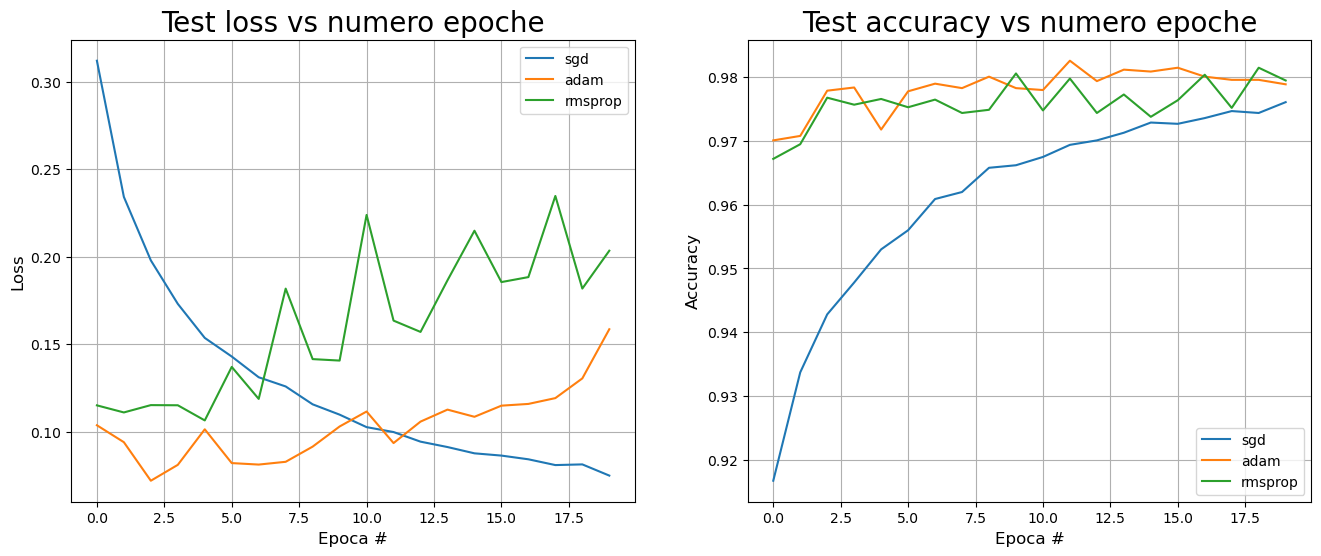

In [9]:
plt.figure(figsize=(16,6))

# Loss
plt.subplot(1,2,1)
for name, H in histories.items():
    plt.plot(H['val_loss'], label=f'{name}')
plt.xlabel('Epoca #', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Test loss vs numero epoche', fontsize=20)
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
for name, H in histories.items():
    plt.plot(H.get('val_acc'), label=f'{name}')
plt.xlabel('Epoca #', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Test accuracy vs numero epoche', fontsize=20)
plt.grid(True)
plt.legend()

plt.show()



Dai due grafici si può constatare quanto segue:

- `sgd`: 
  - La funzione di costo diminuisce in modo regolare e continuo al crescere delle epoche. 
  - L’accuratezza cresce gradualmente ed arriva poco sopra il $97\%$. L’andamento è costante ma richiede molte epoche per raggiungere buoni livelli.  
  
- `adam`: 
  - La funzione di costo parte già molto bassa e raggiunge valori ridotti in poche epoche.
  - L’accuratezza cresce molto rapidamente e supera presto il $98\%$. Dopo le prime epoche si stabilizza, mostrando che l’ottimizzatore ha raggiunto un buon compromesso tra velocità di apprendimento e qualità della generalizzazione.  
  
- `rmsprop`: 
  - La funzione di costo tende invece a crescere con l’aumentare delle epoche. Questo comportamento può essere legato ad un overfitting o ad un problema di instabilità dell'ottimizzatore.
  - L’accuratezza rimane comunque alta (intorno al $97–98\%$), ma presenta oscillazioni maggiori.  

Questo confronto mostra che `adam` è la scelta migliore per questo problema. 
Anche `sgd`rimane una buona alternativa, ma richiede più epoche per raggiungere prestazioni paragonabili. Al contrario `rmsprop` nelle condizioni attuali non è ideale, perché la funzione di loss peggiora con il tempo, segno di eccessivo adattamento ai dati di training.  

Per questo dataset e questa architettura, un numero di epoche $N_{\mathrm{epochs}}=15$ è un buon compromesso. Con poche epoche infatti ($5$ o meno) `adam` converge già bene, oltre le $20$ epoche non si osservano benefici significativi e anzi aumenta il rischio di overfitting.

### Predizioni del modello

Con questi parametri appena scelti, costruisco quindi una DNN e la addestro sul dataset MNIST e infine testo il modello su alcune immagini del set di validazione.  

Confronto quindi le predizioni con le etichette reali, in modo da verificare visivamente la qualità del classificatore.  

In [10]:
# DNN
model, history, loss, accuracy = train_model_DNN(optimizer='adam', N_epochs=15)

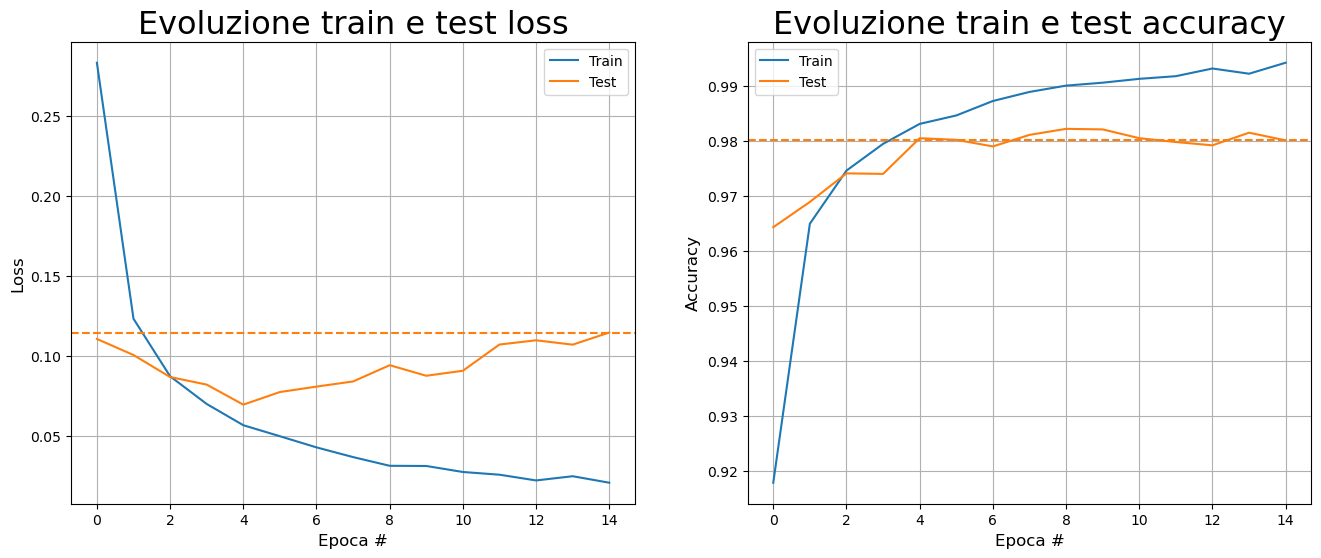

Performance del modello:
Test loss =  0.11455776542425156
Test accuracy =  0.9800999760627747


In [11]:
plt.figure(figsize=(16,6))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.axhline(y=loss, color='tab:orange', linestyle='--')
plt.xlabel('Epoca #', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evoluzione train e test loss', fontsize=23)
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Test')
plt.axhline(y=accuracy, color='tab:orange', linestyle='--')
plt.xlabel('Epoca #', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evoluzione train e test accuracy', fontsize=23)
plt.grid(True)
plt.legend()

plt.show()

print('Performance del modello:')
print('Test loss = ', loss)
print('Test accuracy = ', accuracy)

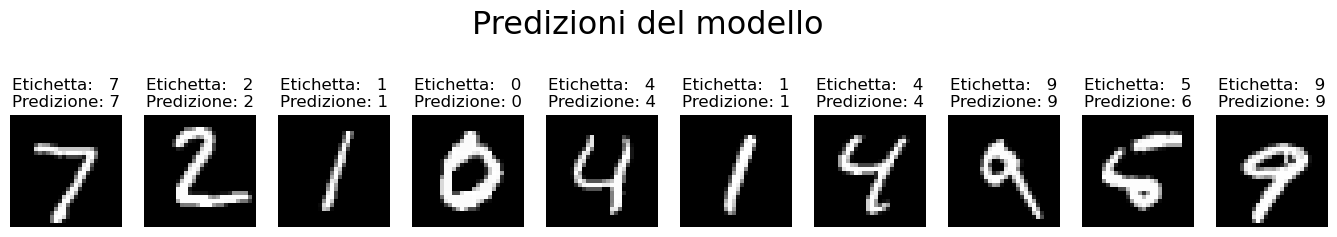

In [13]:
predictions = model.predict(X_test, verbose=0)

X = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(17,17)) 
plt.suptitle('Predizioni del modello', fontsize=23, y=0.8)
for i in range(10):    
    ax = plt.subplot(2, 10, i+1)    
    plt.imshow(X[i, :, :, 0], cmap='gray')    
    plt.title("Etichetta:   {}\nPredizione: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
    
plt.show()

I risultati confermano che il modello è in grado di riconoscere le cifre scritte a mano del dataset MNIST con una accuracy del $98\%$, anche se dai grafici sopra si nota che la loss di test si stabilizza a valori superiori di quella di training, che invece continua a scendere. Questo comportamento indica quindi che con una rete neurale di tipo denso come questa, il modello impara molto bene i dati di training, ma non migliora oltre un certo punto sui dati di test.

## <span id="ex012_2">  Esercizio 12.2 </span>[^](#toc)

A questo punto costruisco una rete neurale convoluzionale, che a differenza della rete neurale precedente è più adatta nell'utilizzo di immagini perché sfrutta la struttura bidimensionale dei dati.

Questa rete infatti non utilizza solo layer densi, ma implementa dei filtri che estraggono feature locali in modo da poter riconoscere anche correlazioni spaziali tra i pixel. Per questo motivo è necessario ridefinire i dati iniziali, mantenendo la struttura originale delle immagini.

Il procedimento di definizione della rete è simile a quello visto nel punto precedente. Utilizzo gli stessi parametri ottimizzati, ovvero $N_{\mathrm{epochs}}=15$ e `adam` come ottimizzatore, in modo da poter confrontare direttamente le prestazioni con la DNN.

In [14]:
# 1. Load and process data
# Train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Reshape data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# Cast to floats and rescale data in interval [0,1]
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [15]:
# 2. Define CNN architecture
def create_CNN():
    # Instantiate model
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Add a first convolutional block: Conv + Pooling + Dropout
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    # Add a second convolutional block: Conv + Pooling + Dropout
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # Soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [16]:
# 3. Compile CNN model 
def compile_model_CNN(optimizer):
    # Create the model
    model=create_CNN()
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['acc'])
    return model

In [17]:
# 4. Train CNN model
def train_model_CNN(optimizer, N_epochs):
    # Create the deep neural net
    model = compile_model_CNN(optimizer)
    # Train DNN and store training info in history
    history = model.fit(X_train, Y_train,
          batch_size=32,
          epochs=N_epochs,
          shuffle=True, 
          verbose=0,
          validation_data=(X_test, Y_test))
    
    loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
    return model, history, loss, accuracy

In [18]:
# CNN
model, history, loss, accuracy = train_model_CNN(optimizer='adam', N_epochs=15)

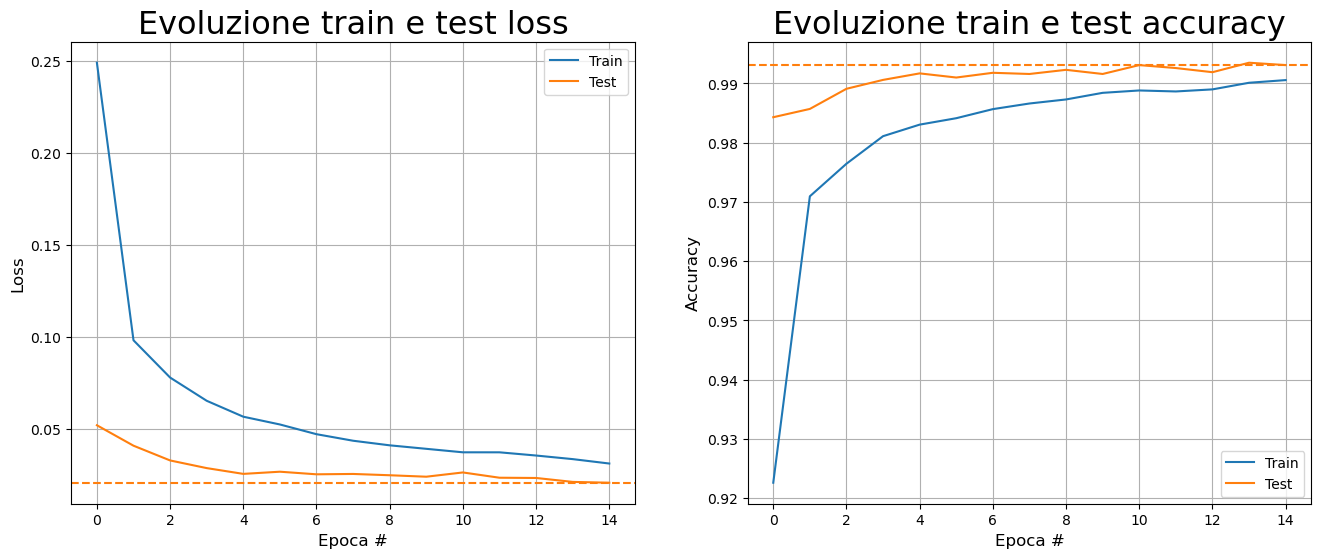

Performance del modello:
Test loss =  0.020559508353471756
Test accuracy =  0.9930999875068665


In [19]:
plt.figure(figsize=(16,6))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.axhline(y=loss, color='tab:orange', linestyle='--')
plt.xlabel('Epoca #', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evoluzione train e test loss', fontsize=23)
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Test')
plt.axhline(y=accuracy, color='tab:orange', linestyle='--')
plt.xlabel('Epoca #', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evoluzione train e test accuracy', fontsize=23)
plt.grid(True)
plt.legend()

plt.show()

print('Performance del modello:')
print('Test loss = ', loss)
print('Test accuracy = ', accuracy)

Dai grafici si osserva che sul test set la funzione loss converge rapidamente, raggiungendo valori $\approx0.02$ e l'accuracy raggiunge il $99.3\%$.  

Le curve di training e test rimangono vicine tra loro senza segni evidenti di overfitting, grazie anche all’uso di Dropout e Pooling durante la costruzione della rete.  

Si nota inoltre che già entro le prime $10$ epoche il modello ha praticamente raggiunto le prestazioni massime, quindi $N_{\mathrm{epochs}}=15$ risulta una scelta adeguata per garantire la convergenza senza spreco di tempo computazionale.  

Rispetto alla rete DNN del punto precedente, la CNN come anticipato ottiene prestazioni più alte e più stabili.

## <span id="ex012_3">  Esercizio 12.3 </span>[^](#toc)

In quest’ultima parte verifico il funzionamento della CNN addestrata su MNIST usando $10$ immagini create da me usando GIMP.  

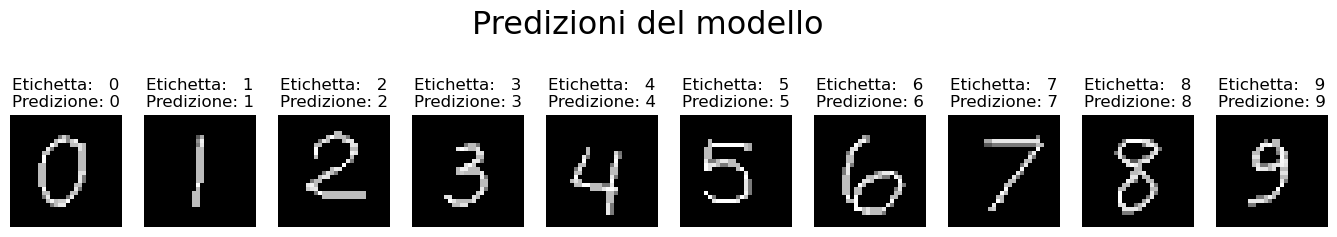

In [22]:
digit_filenames = [ "digits/0.png",
                    "digits/1.png",
                    "digits/2.png",
                    "digits/3.png",
                    "digits/4.png",
                    "digits/5.png",
                    "digits/6.png",
                    "digits/7.png",
                    "digits/8.png",
                    "digits/9.png", ]
data = []

for digit_filename in digit_filenames:
    digit_in = Image.open(digit_filename).convert('L').resize((28, 28))
    xdim, ydim = digit_in.size
    img = np.asarray(digit_in, dtype=np.float32)/255
    data.append(img)
    
    
predictions = [0]*10
for i in range(10):
    arr4d = data[i].reshape(1, 28, 28, 1)
    predictions[i] = model.predict(arr4d, verbose=0)
    
plt.figure(figsize=(17,17))     
plt.suptitle('Predizioni del modello', fontsize=23, y=0.8)
for i in range(10):    
    ax = plt.subplot(2, 10, i+1)    
    plt.imshow(data[i], cmap='gray')    
    plt.title("Etichetta:   "+str(i)+"\nPredizione: {}".format(np.argmax(predictions[i])))    
    plt.axis('off') 

plt.show()

Il modello è riuscito riconoscere correttamente tutte le $10$ cifre fornite, dimostrando quindi una buona capacità di generalizzazione anche al di fuori del dataset originale. 